In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import PIL
import cv2 
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.python.client import device_lib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,MaxPooling2D,Conv2D,Dropout,Activation,BatchNormalization
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report,confusion_matrix
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import warnings 
warnings.filterwarnings('ignore')

## M1 gpu'yu çalıştırmaya çalıştım ama bir türlü tensorflow gpumu tanımadı
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

GPU is NOT AVAILABLE


In [2]:

#dataset: https://www.kaggle.com/datasets/prashant268/chest-xray-covid19-pneumonia
#Covid-19 class'ı da vardı ama iki class bile makinemi yorarken üç class ile denemeye cesaret edemedim.


#train_dir = ("xray_dataset_covid19/train") #küçük dataset(daha hızlı ama less accurate)
#test_dir = ("xray_dataset_covid19/test")

train_dir = ("big-dataset/train") #büyük dataset (more accurate ama training 2 saat sürüyor),
test_dir = ("big-dataset/test")
##macOs .dsstore diye bir dosya oluşturduğu için gizli dosyaları (. ile başlayanları) ignoreladım
classes_train = [item for item in os.listdir(train_dir) if not item.startswith('.')]
classes_test = [item for item in os.listdir(test_dir) if not item.startswith('.')]

classes_train

['PNEUMONIA', 'NORMAL']

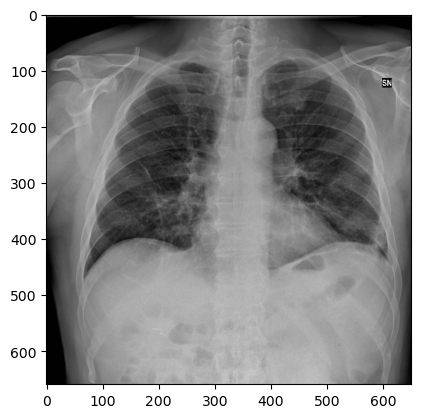

In [3]:
plt.imshow(cv2.imread("xray_dataset_covid19/train/PNEUMONIA/9C34AF49-E589-44D5-92D3-168B3B04E4A6.jpeg")) #pneumonia'lı

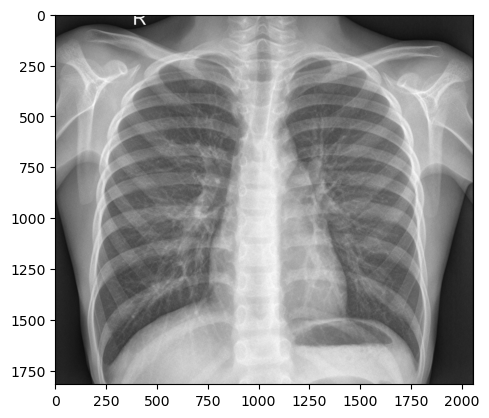

In [4]:
plt.imshow(cv2.imread("xray_dataset_covid19/train/NORMAL/IM-0007-0001.jpeg")) #sağlıklı

In [5]:
train_datagen=ImageDataGenerator(
    #zoom_range=0.2, #the amount of zooming u need
    horizontal_flip=True, # Make a horizontal copy of image
    rescale=1/255, # Normalize the new images
    width_shift_range=0.10, # The percentage of Width shifitning
    height_shift_range=0.10, # The percentage of height shifitning
    shear_range=0.1, #Shear angle in counter-clockwise direction in degrees
    fill_mode='nearest',
    rotation_range=20, 
)
train_generator=train_datagen.flow_from_directory(
    train_dir,
    class_mode='binary',
    color_mode='rgb',
    batch_size= 16,
    target_size=(1000,1000,3)[:2]
)
##TODO: Documentation'ı oku https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
test_datagen=ImageDataGenerator(rescale=1/255)
test_generator=test_datagen.flow_from_directory(
    test_dir,
    class_mode='binary',
    color_mode='rgb',
    batch_size=16,
    target_size=(1000,1000,3)[:2]
)

Found 4684 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.


In [6]:
earlystop=EarlyStopping(patience=6)
learning_rate_reduction=ReduceLROnPlateau(
    monitor='val_accuracy',
    patience= 3,
    verbose=1,
    factor=0.5,
    min_lr=0.00001
)
callbacks = [earlystop, learning_rate_reduction]

In [7]:
model=Sequential() 

model.add(Conv2D(32,(2,2),activation='relu',input_shape=(1000,1000,3)))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64,(2,2),activation='relu'))
model.add(MaxPooling2D(3,3))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(3,3))

model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128,activation='relu'))

model.add(Dropout(0.4))
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer='adam' ,loss='binary_crossentropy',metrics=['accuracy'])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 999, 999, 32)      416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 499, 499, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 498, 498, 64)      8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 166, 166, 64)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 164, 164, 64)      36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 54, 54, 64)       0

In [9]:
model.fit(
    train_generator, 
    epochs=10,
    validation_data=test_generator,
    callbacks=callbacks
)

Epoch 1/10
293/293 [==============================] - 1727s 6s/step - loss: 0.4444 - accuracy: 0.7957 - val_loss: 0.4116 - val_accuracy: 0.8063 - lr: 0.0010
Epoch 2/10
293/293 [==============================] - 1917s 7s/step - loss: 0.2962 - accuracy: 0.8723 - val_loss: 0.1841 - val_accuracy: 0.9317 - lr: 0.0010
Epoch 3/10
293/293 [==============================] - 1866s 6s/step - loss: 0.2513 - accuracy: 0.8909 - val_loss: 0.1718 - val_accuracy: 0.9300 - lr: 0.0010
Epoch 4/10
293/293 [==============================] - 1792s 6s/step - loss: 0.2292 - accuracy: 0.9097 - val_loss: 0.1656 - val_accuracy: 0.9445 - lr: 0.0010
Epoch 5/10
293/293 [==============================] - 1755s 6s/step - loss: 0.2124 - accuracy: 0.9157 - val_loss: 0.2149 - val_accuracy: 0.9113 - lr: 0.0010
Epoch 6/10
293/293 [==============================] - 1773s 6s/step - loss: 0.2097 - accuracy: 0.9210 - val_loss: 0.1460 - val_accuracy: 0.9437 - lr: 0.0010
Epoch 7/10
293/293 [==============================] - 1803

<Axes: >

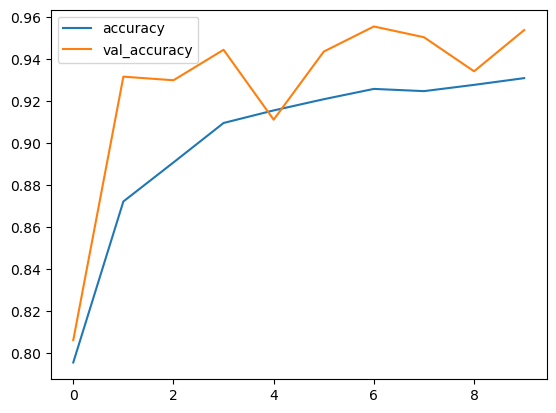

In [10]:
losses = pd.DataFrame(model.history.history)
losses[['accuracy','val_accuracy']].plot()

<Axes: >

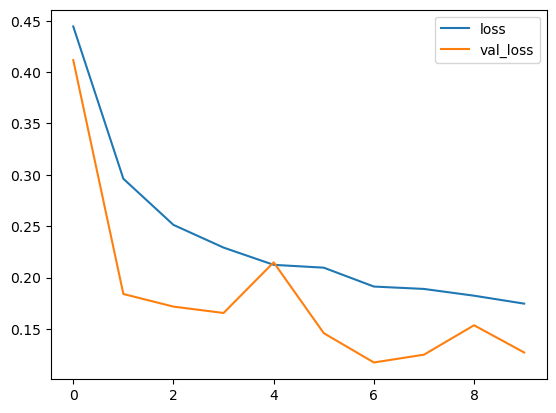

In [11]:
losses[['loss','val_loss']].plot()

In [12]:
model.evaluate(test_generator)

74/74 [==============================] - 80s 1s/step - loss: 0.1272 - accuracy: 0.9539


[0.12715309858322144, 0.9539248943328857]

In [13]:
real = test_generator.classes
real

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [14]:
predictions = model.predict_generator(test_generator) > 0.5
predictions

array([[False],
       [False],
       [False],
       ...,
       [ True],
       [ True],
       [ True]])

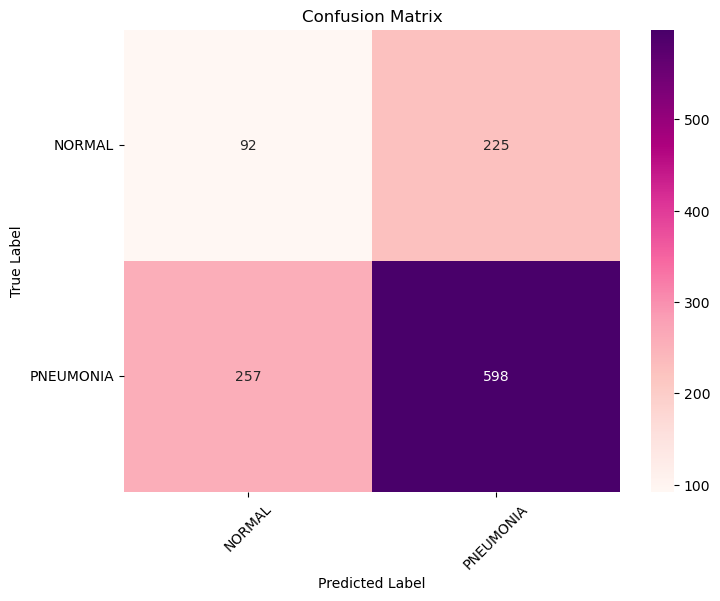

In [15]:
class_names = ["NORMAL", "PNEUMONIA"]

con = confusion_matrix(real, predictions)

plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(con, cmap="RdPu", annot=True, fmt="d") #RdPu rengi hoşuma gittiği için kullandım

heatmap.set_xticklabels(class_names, rotation=45)
heatmap.set_yticklabels(class_names, rotation=0)
heatmap.set_xlabel('Predicted Label')
heatmap.set_ylabel('True Label')
heatmap.set_title('Confusion Matrix')

plt.show()


In [16]:
print('report :',classification_report(real, predictions ))

report :               precision    recall  f1-score   support

           0       0.26      0.29      0.28       317
           1       0.73      0.70      0.71       855

    accuracy                           0.59      1172
   macro avg       0.50      0.49      0.49      1172
weighted avg       0.60      0.59      0.59      1172



1/1 [==============================] - 0s 138ms/step
Prediction: Normal


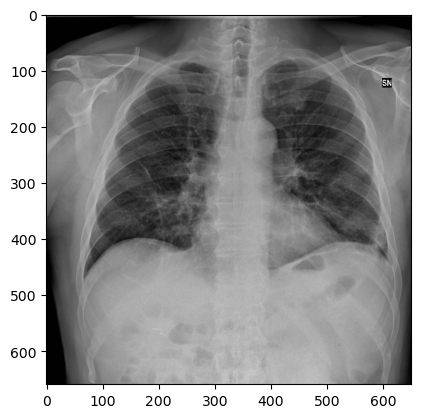

In [17]:
predict_path='xray_dataset_covid19/train/PNEUMONIA/9C34AF49-E589-44D5-92D3-168B3B04E4A6.jpeg' # test etmek için annemin ciğer filmini kullandım
#predict_path='big-dataset/test/normal/NORMAL(1266).jpg'
plt.imshow(cv2.imread(predict_path))

my_image = image.load_img(predict_path,target_size=(1000,1000,3))
my_image = np.expand_dims(my_image,axis = 0)
prediction = np.argmax(model.predict(my_image))

if prediction == 0:
    print("Prediction: Normal")
elif prediction == 1:
    print("Prediction: Pneumonia")
else:
    print("An error occurred while predicting")